# Customer Churn Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import matplotlib.patches as mpatches
import matplotlib as matplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression,mutual_info_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC,SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score

In [2]:
#read the csv file in a dataframe
churn_df = pd.read_csv("Customer_churn_raw.csv")

churn_df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [3]:
#rename the columns
churn_df=churn_df.rename(columns={"Call  Failure": "call_failure", "Complains": "complains", "Subscription  Length": "subs_len", "Charge  Amount": "charge_amount",
                   "Seconds of Use": "seconds_of_use", "Frequency of use": "freq_of_use", "Frequency of SMS": "freq_of_sms", "Distinct Called Numbers": "distinct_call_nums",
                   "Age Group": "age_group", "Tariff Plan": "tariff_plan", "Status": "status", "Age": "age", "Customer Value": "customer_value"})

In [4]:
#print the columns
churn_df.columns

Index(['call_failure', 'complains', 'subs_len', 'charge_amount',
       'seconds_of_use', 'freq_of_use', 'freq_of_sms', 'distinct_call_nums',
       'age_group', 'tariff_plan', 'status', 'age', 'customer_value', 'Churn'],
      dtype='object')

## Exploratory Data Analysis

In [5]:
#filter out the 3 columns from the dataframe
cols_3 = churn_df[['call_failure', 'complains', 'subs_len']]

cols_3

,call_failure,complains,subs_len
0,8,0,38
1,0,0,39
2,10,0,37
3,10,0,38
4,3,0,38
...,...,...,...
3145,21,0,19
3146,17,0,17
3147,13,0,18
3148,7,0,11


In [6]:
cols_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   call_failure  3150 non-null   int64
 1   complains     3150 non-null   int64
 2   subs_len      3150 non-null   int64
dtypes: int64(3)
memory usage: 74.0 KB


In [7]:
cols_3.describe()

,call_failure,complains,subs_len
count,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905
std,7.263886,0.265851,8.573482
min,0.000000,0.000000,3.000000
25%,1.000000,0.000000,30.000000
50%,6.000000,0.000000,35.000000
75%,12.000000,0.000000,38.000000
max,36.000000,1.000000,47.000000


### Check for null values

In [8]:
#check for null values in 
cols_3.isna().sum()

call_failure    0
complains       0
subs_len        0
dtype: int64

## Data Visualization Before Data Cleaning

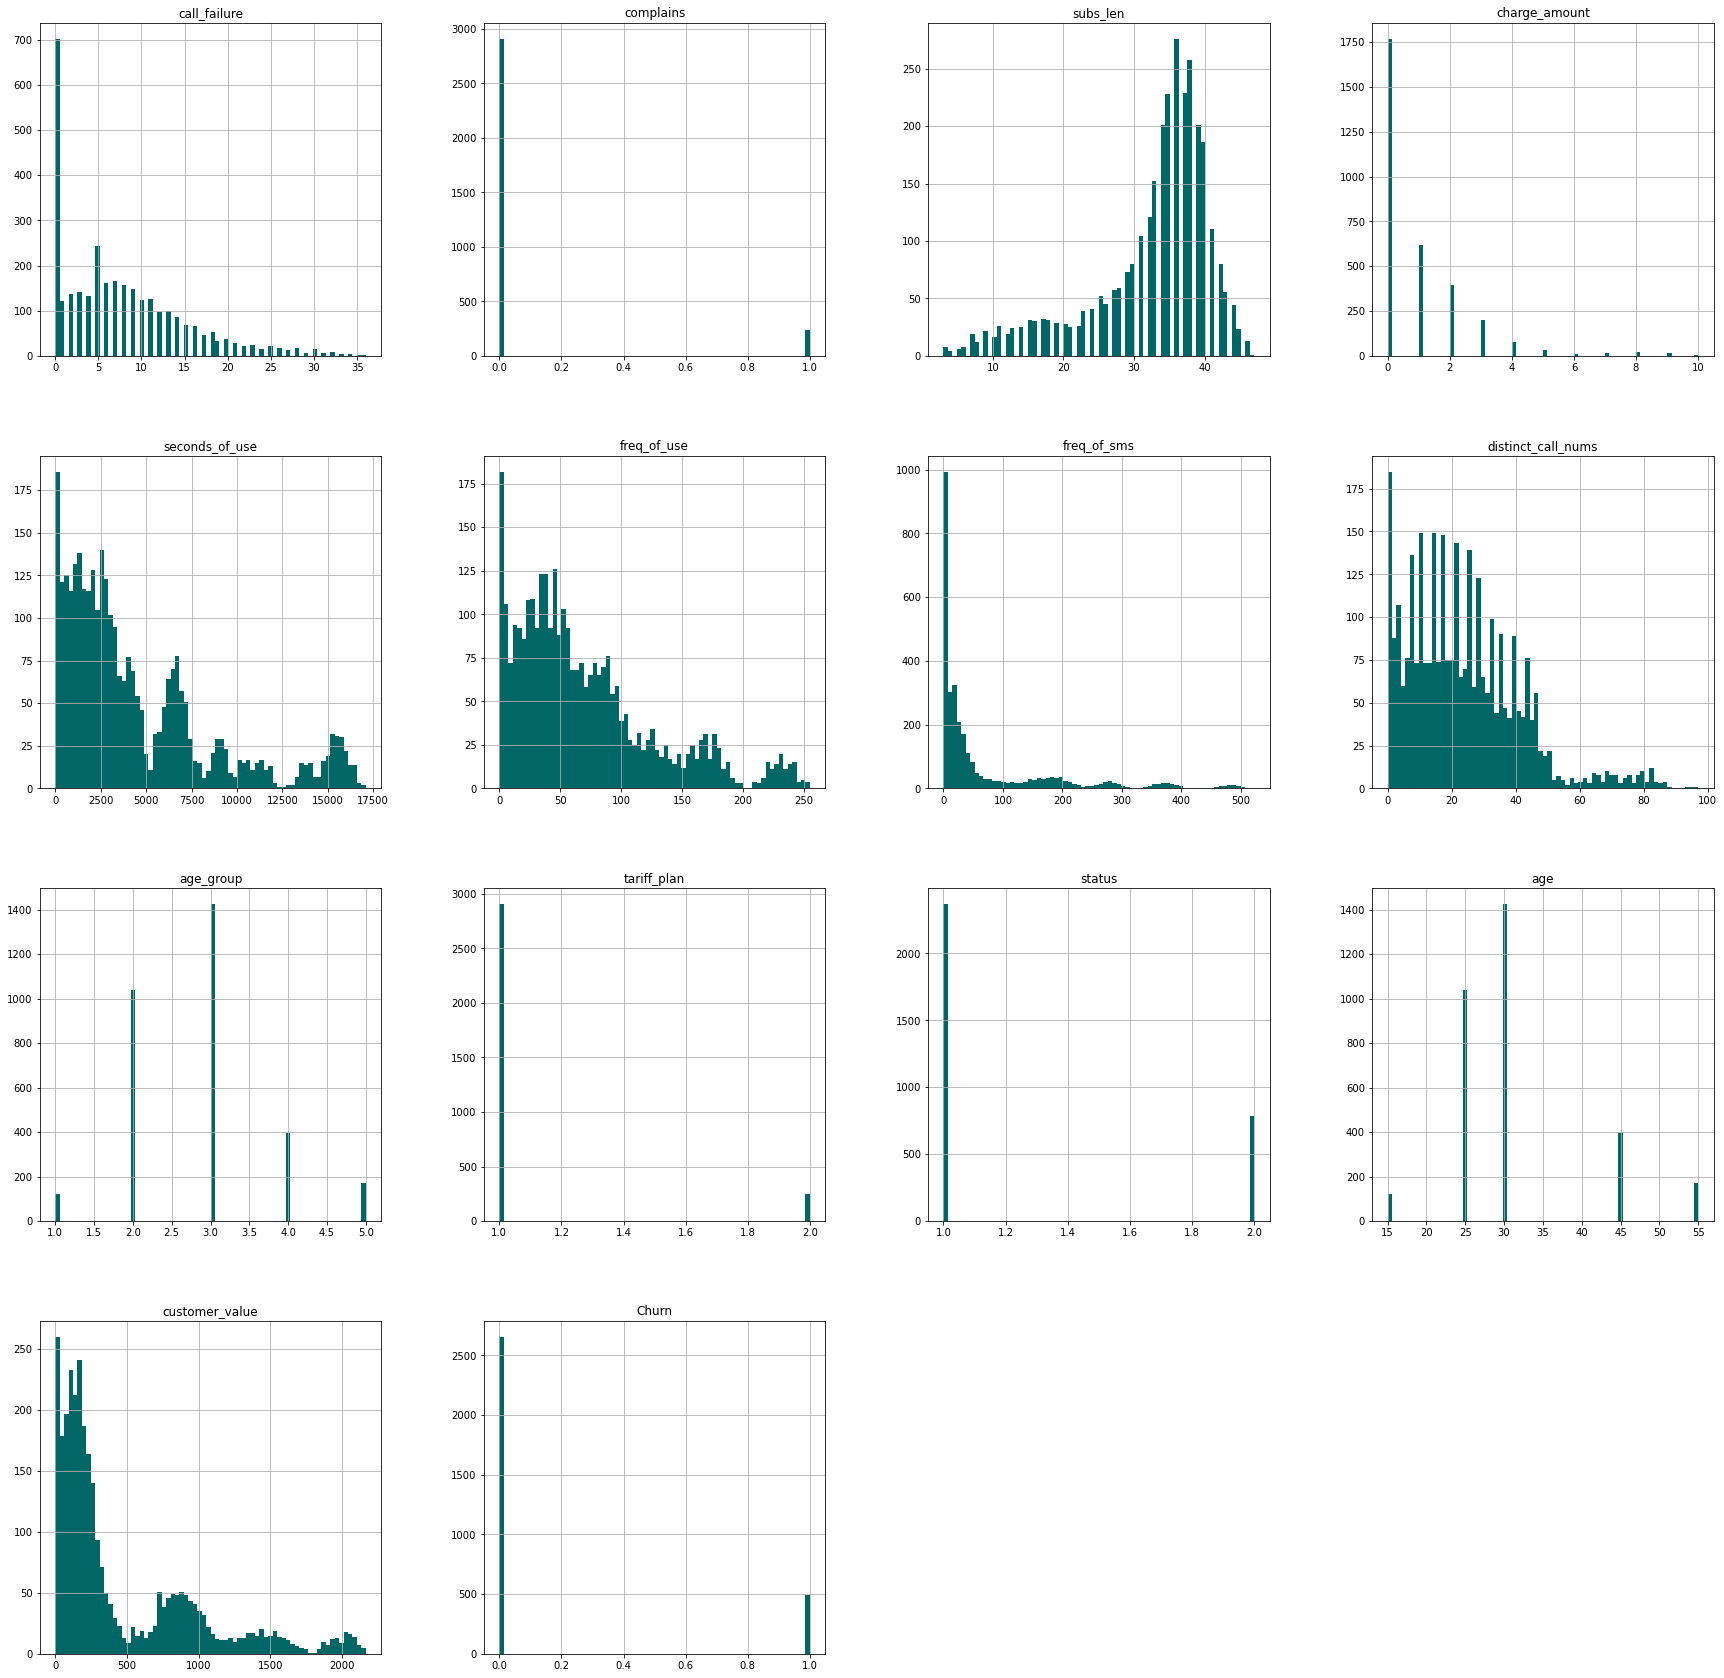

In [9]:

# Frequency distribution of all the columns

churn_df.hist(bins=70,figsize=(30,30),color=(0,0.4,0.4))
plt.show()


#### Observation: 
 Frequency distribution of all the columns are shown above before data cleaning

## Value counts of all the columns

<Figure size 2304x2304 with 0 Axes>

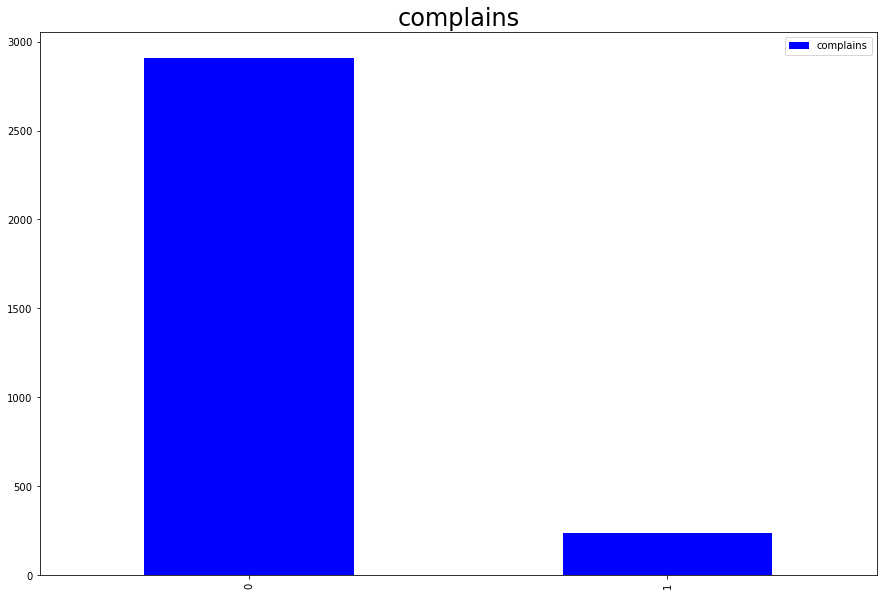

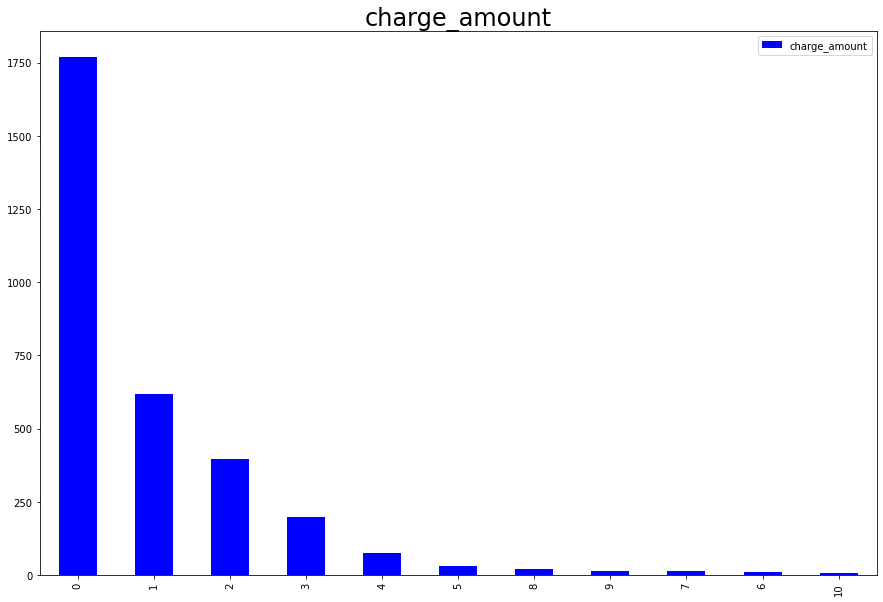

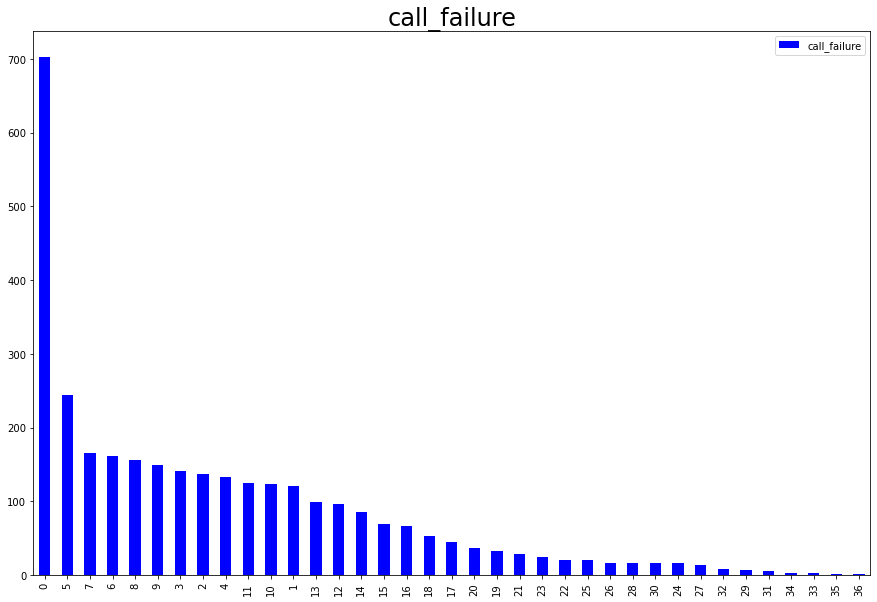

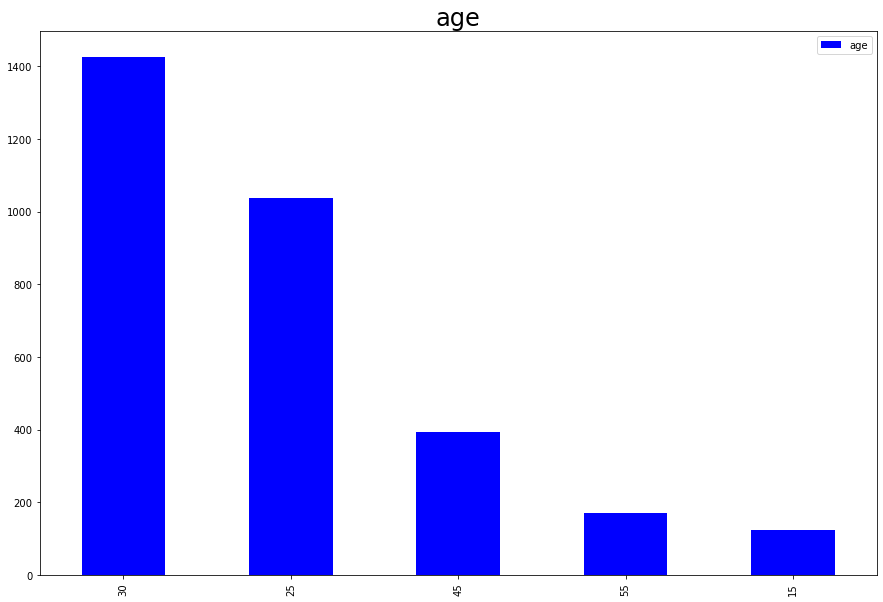

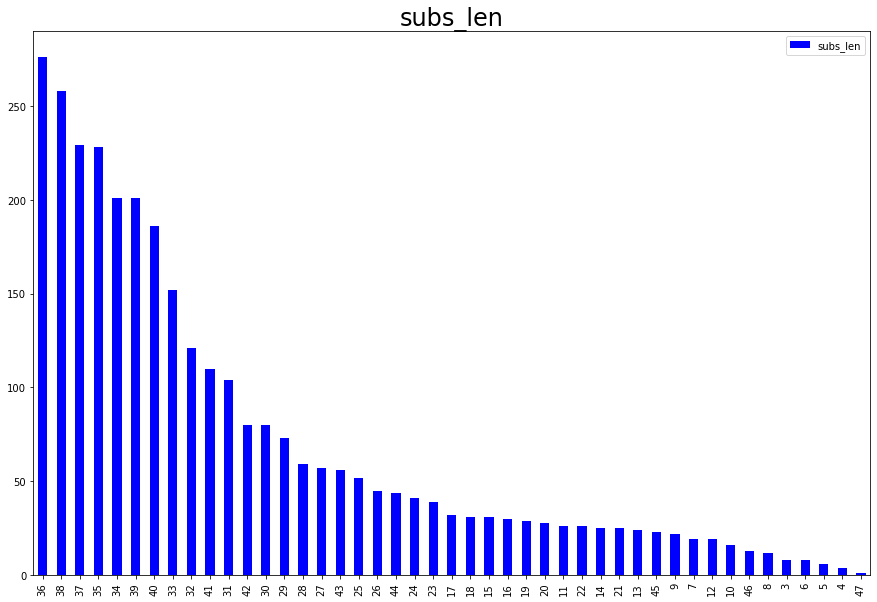

In [10]:
import matplotlib

plt.figure(figsize=(32, 32))
matplotlib.rc('axes', titlesize=24)#cols size

columns=["complains", "charge_amount", "call_failure", "age",'subs_len']
for i, column in enumerate(columns, 1):
    pd.DataFrame(churn_df[column].value_counts()).plot(kind='bar',figsize=(15,10),color="blue")
    plt.legend(fontsize='medium')
    plt.title(column)

#### Observations:
Age column has some negative and string values which need to be changed

Charge amount has some string values which need to be changed

Charge amount has some string values which need to be changed

Call failure has some negatve values and outliers which need to be cleaned

Subscription length has some negative values which needs to cleaned

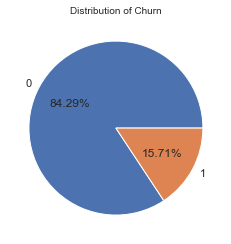

In [11]:
# Churn distribution 
sn.set(style="whitegrid",font_scale=1)
plt.figure(figsize=(4,4))
plt.pie(churn_df.Churn.value_counts(), labels=churn_df.Churn.unique(), autopct='%1.2f%%')
plt.title('Distribution of Churn', fontsize = 10)
plt.show()

#### Observations
 
There are 84.29% Non churn value and 15.71% churn values are there

## Box Plot

Boxplot is a chart that is used to visualize how a given data (variable) is distributed using quartiles. It shows the minimum, maximum, median, first quartile and third quartile in the data set.

<AxesSubplot:>

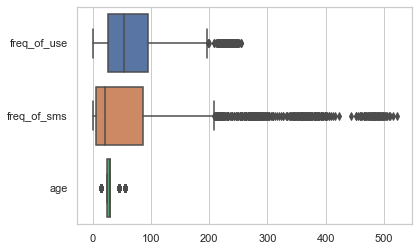

In [27]:
sn.boxplot(data=churn_df[["freq_of_use", "freq_of_sms","age"]], orient="h")

<AxesSubplot:>

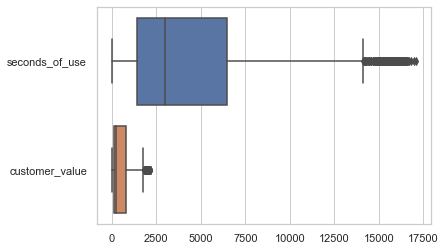

In [25]:
sn.boxplot(data=churn_df[["seconds_of_use", "customer_value"]], orient="h")


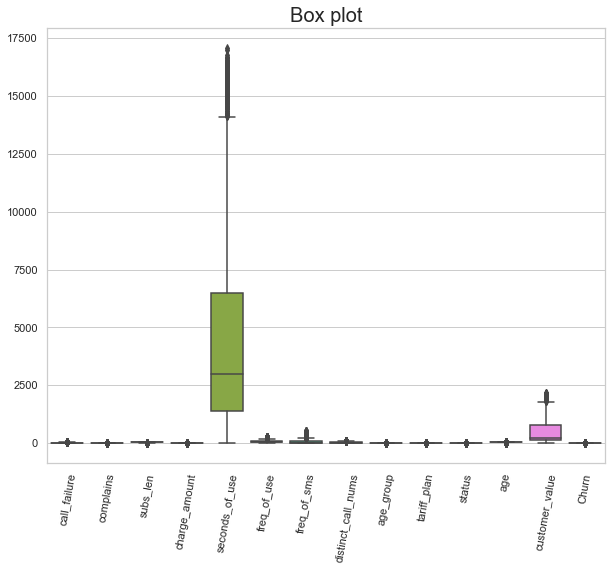

In [12]:
sn.set(style="whitegrid",font_scale=1)
plt.figure(figsize=(10,8))
sn.boxplot(data=churn_df)
plt.xticks(rotation=80)
plt.title("Box plot",fontsize = 20)
plt.show()

 #### Observation1: 
 As we can see there are outliers in our dataset, especially in cutsomer_value andseconds_of_use have more outliers


### Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses. Create your own correlation matrix.

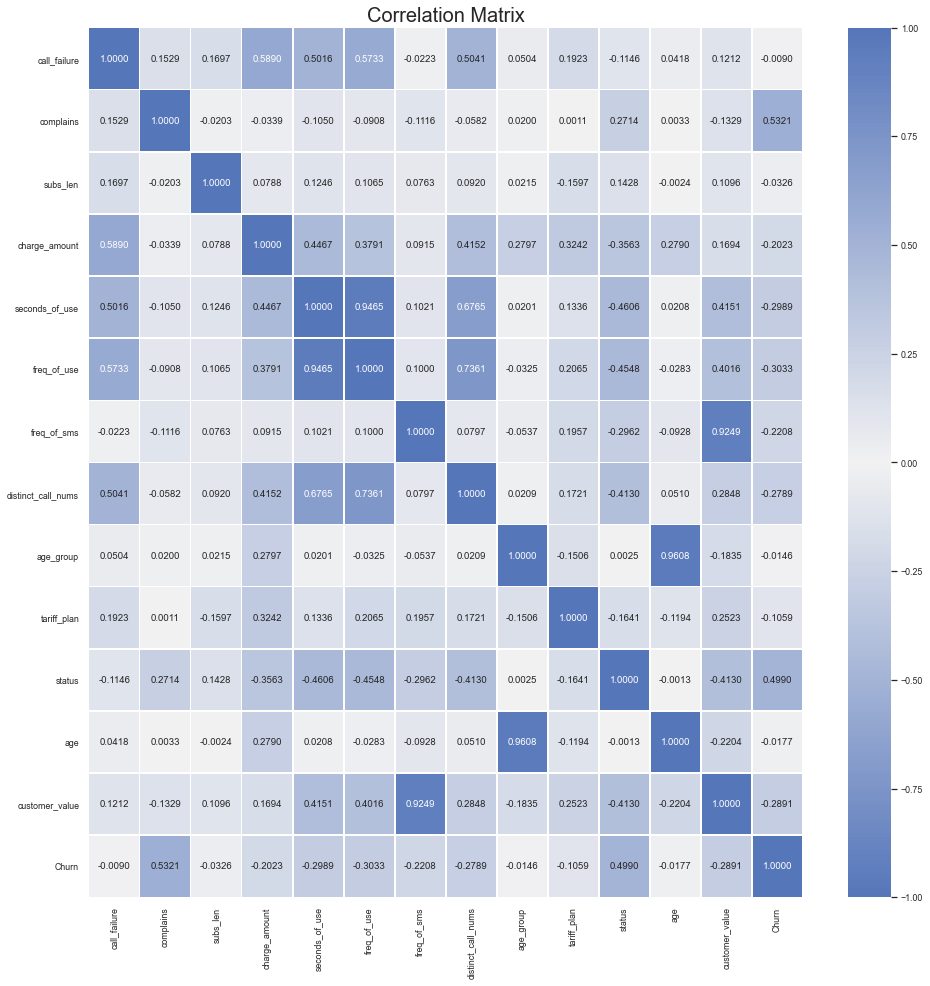

In [13]:
df_corr = churn_df.corr()

# correlation matrix

sn.set(font_scale=0.8)
plt.figure(figsize=(16,16))
plt.title("Correlation Matrix",fontsize = 20)
sn.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, 
           cmap = sn.diverging_palette(255, 255, s=60, as_cmap=True))
plt.show()

### Data cleaning

In [14]:
cols_3['call_failure'].value_counts()

0     702
5     244
7     166
6     161
8     156
9     149
3     141
2     137
4     133
11    125
10    124
1     121
13     99
12     97
14     85
15     69
16     67
18     53
17     45
20     37
19     33
21     29
23     25
22     21
25     21
26     17
28     17
30     16
24     16
27     13
32      8
29      7
31      6
34      3
33      3
35      2
36      2
Name: call_failure, dtype: int64

**Observation:** Since the data is not consistent, we'll replace these values

In [15]:
cols_3['call_failure'] = pd.to_numeric(cols_3['call_failure'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)

In [16]:
cols_3['complains'].value_counts()

0    2909
1     241
Name: complains, dtype: int64

 **Observation:** Since complains is boolean type we will chave to replace with weither 0 or 1

In [17]:
cols_3['complains'] = pd.to_numeric(cols_3['complains'].astype(str), errors='coerce').fillna(0).astype(int)

In [18]:
cols_3['complains'].value_counts()

0    2909
1     241
Name: complains, dtype: int64

In [19]:
cols_3.loc[cols_3['complains'] != 0, 'complains'] = 1

In [20]:
# Verification
cols_3['complains'].value_counts()

0    2909
1     241
Name: complains, dtype: int64

In [21]:
#Clean the subscription length column
cols_3['subs_len'].value_counts()

36    276
38    258
37    229
35    228
34    201
39    201
40    186
33    152
32    121
41    110
31    104
42     80
30     80
29     73
28     59
27     57
43     56
25     52
26     45
44     44
24     41
23     39
17     32
18     31
15     31
16     30
19     29
20     28
11     26
22     26
14     25
21     25
13     24
45     23
9      22
7      19
12     19
10     16
46     13
8      12
3       8
6       8
5       6
4       4
47      1
Name: subs_len, dtype: int64

In [22]:
cols_3['subs_len'] = cols_3['subs_len'].abs()

In [23]:
cols_3['subs_len'].value_counts()

36    276
38    258
37    229
35    228
34    201
39    201
40    186
33    152
32    121
41    110
31    104
42     80
30     80
29     73
28     59
27     57
43     56
25     52
26     45
44     44
24     41
23     39
17     32
18     31
15     31
16     30
19     29
20     28
11     26
22     26
14     25
21     25
13     24
45     23
9      22
7      19
12     19
10     16
46     13
8      12
3       8
6       8
5       6
4       4
47      1
Name: subs_len, dtype: int64

In [24]:
cols_3['subs_len'].fillna(value=cols_3['subs_len'].mean(), inplace=True)

In [25]:
cols_3['subs_len'] = cols_3['subs_len'].astype(int)

In [26]:
cols_3.dtypes

call_failure    int32
complains       int32
subs_len        int32
dtype: object

In [27]:
cols_3['subs_len'].value_counts()

36    276
38    258
37    229
35    228
34    201
39    201
40    186
33    152
32    121
41    110
31    104
42     80
30     80
29     73
28     59
27     57
43     56
25     52
26     45
44     44
24     41
23     39
17     32
18     31
15     31
16     30
19     29
20     28
11     26
22     26
14     25
21     25
13     24
45     23
9      22
7      19
12     19
10     16
46     13
8      12
3       8
6       8
5       6
4       4
47      1
Name: subs_len, dtype: int64

In [28]:
# Verification for null values

cols_3.isna().sum()

call_failure    0
complains       0
subs_len        0
dtype: int64

In [29]:
churn_df = churn_df.drop(['call_failure', 'complains', 'subs_len'],axis = 1)
churn_df = pd.concat([cols_3,churn_df],axis = 1)

In [30]:
churn_df.isnull().sum()

call_failure          0
complains             0
subs_len              0
charge_amount         0
seconds_of_use        0
freq_of_use           0
freq_of_sms           0
distinct_call_nums    0
age_group             0
tariff_plan           0
status                0
age                   0
customer_value        0
Churn                 0
dtype: int64

In [31]:
#Filter the dataframe for cleaning and analysis

col_4_5_12 = churn_df.filter(['charge_amount','customer_value','seconds_of_use','Churn'], axis=1)


In [32]:
#Summary of the dataframe

col_4_5_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   charge_amount   3150 non-null   int64  
 1   customer_value  3150 non-null   float64
 2   seconds_of_use  3150 non-null   int64  
 3   Churn           3150 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 98.6 KB


In [33]:
#count the total number of null values in all the columns

col_4_5_12.isnull().sum()

charge_amount     0
customer_value    0
seconds_of_use    0
Churn             0
dtype: int64

In [34]:
# Count the unique values in 'customer_value' column

col_4_5_12['customer_value'].value_counts()

0.000      132
45.495      11
40.440      10
15.165       6
25.275       5
          ... 
111.850      1
49.040       1
147.080      1
174.520      1
286.440      1
Name: customer_value, Length: 2654, dtype: int64

In [35]:
col_4_5_12['charge_amount'].value_counts()

0     1768
1      617
2      395
3      199
4       76
5       30
8       19
9       14
7       14
6       11
10       7
Name: charge_amount, dtype: int64

#### Observations:

Charge_amount has String values and negative values which needs to be replaced

In [36]:
#Replace incorrect values with correct values

col_4_5_12['charge_amount'].replace(['OOO','OO','0','o','o0'], 0, inplace=True )
col_4_5_12['charge_amount'].replace(['o1'], 1, inplace=True )
col_4_5_12['charge_amount'].replace(['o7'], 7, inplace=True )
col_4_5_12['charge_amount'].replace(['o2'], 2, inplace=True )
col_4_5_12['charge_amount'].replace(['o4'], 4, inplace=True )
col_4_5_12['charge_amount'].replace(['o8'], 8, inplace=True )
col_4_5_12['charge_amount'].replace(['o5'], 5, inplace=True )
col_4_5_12['charge_amount'].replace(['o3'], 3, inplace=True )
col_4_5_12['charge_amount'].replace(['o6'], 6, inplace=True )
col_4_5_12['charge_amount'].replace(['2.00001'], 2, inplace=True )

In [37]:
# Convert datatype to intgere and make negatives positive

col_4_5_12['charge_amount'] = col_4_5_12['charge_amount'].astype(int)
col_4_5_12['charge_amount'] = col_4_5_12['charge_amount'].abs()

In [38]:
# Count the unique values in 'charge_amount' column

col_4_5_12['charge_amount'].value_counts()

0     1768
1      617
2      395
3      199
4       76
5       30
8       19
9       14
7       14
6       11
10       7
Name: charge_amount, dtype: int64

In [39]:
# Count the unique values in 'seconds_of_use' column

col_4_5_12['seconds_of_use'].value_counts()

0        154
305       37
1973       9
2088       9
1015       9
        ... 
14540      1
205        1
10450      1
2260       1
6143       1
Name: seconds_of_use, Length: 1756, dtype: int64

In [40]:
# Convert datatype to intgere and make negatives positive

col_4_5_12['seconds_of_use'].replace(['O3915'], 3915, inplace=True )
col_4_5_12['seconds_of_use'] = col_4_5_12['seconds_of_use'].astype(int)
col_4_5_12['seconds_of_use'] = col_4_5_12['seconds_of_use'].abs()

In [41]:
# Count the unique values in 'seconds_of_use' column

col_4_5_12['seconds_of_use'].value_counts()

0        154
305       37
1973       9
2088       9
1015       9
        ... 
14540      1
205        1
10450      1
2260       1
6143       1
Name: seconds_of_use, Length: 1756, dtype: int64

In [42]:
# Count the total number fo null values 

col_4_5_12.isnull().sum()

charge_amount     0
customer_value    0
seconds_of_use    0
Churn             0
dtype: int64

In [43]:
# Get the summary of dataframe

col_4_5_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   charge_amount   3150 non-null   int32  
 1   customer_value  3150 non-null   float64
 2   seconds_of_use  3150 non-null   int32  
 3   Churn           3150 non-null   int64  
dtypes: float64(1), int32(2), int64(1)
memory usage: 74.0 KB


In [44]:
col_4_5_12 = col_4_5_12.drop(['Churn'],axis = 1)
churn_df = churn_df.drop(['charge_amount','seconds_of_use'],axis = 1)
churn_df = churn_df.drop(['customer_value'],axis = 1)
churn_df = pd.concat([col_4_5_12,churn_df],axis = 1)

In [45]:
churn_df = churn_df[['call_failure', 'complains', 'subs_len', 'charge_amount',
       'seconds_of_use', 'freq_of_use', 'freq_of_sms', 'distinct_call_nums',
       'tariff_plan', 'status', 'age', 'customer_value', 'Churn']]
churn_df.head()

,call_failure,complains,subs_len,charge_amount,seconds_of_use,freq_of_use,freq_of_sms,distinct_call_nums,tariff_plan,status,age,customer_value,Churn
0,8,0,38,0,4370,71,5,17,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,15,145.805,0


### Check for Max and Min Values in columns

Description about the columns:
1. Frequency of use: total number of calls
2. Frequency of SMS: total number of text messages
3. Distinct Called Numbers: total number of distinct phone calls

In [46]:
# Checking if there are any negative values or extreme values. As these columns cant have negative numbers as values
print('Maximum value in freq_of_use',churn_df['freq_of_use'].max())
print('Minimum value in freq_of_use',churn_df['freq_of_use'].min())
print('Maximum value in freq_of_sms',churn_df['freq_of_sms'].max())
print('Minimum value in freq_of_sms',churn_df['freq_of_sms'].min())
print('Maximum value in distinct_call_nums',churn_df['distinct_call_nums'].max())
print('Minimum value in distinct_call_nums',churn_df['distinct_call_nums'].min())

Maximum value in freq_of_use 255
Minimum value in freq_of_use 0
Maximum value in freq_of_sms 522
Minimum value in freq_of_sms 0
Maximum value in distinct_call_nums 97
Minimum value in distinct_call_nums 0


Observation
1. freq_of_use, freq_of_sms has some negative values
2. distinct_call_nums has no negative values

In [47]:
#Checking if there are any negative values or extreme values. As these columns cant have negative numbers as values
print('Minimum value in freq_of_use',churn_df['freq_of_use'].min())
print('Minimum value in freq_of_sms',churn_df['freq_of_sms'].min())
print('Minimum value in distinct_call_nums',churn_df['distinct_call_nums'].min())

Minimum value in freq_of_use 0
Minimum value in freq_of_sms 0
Minimum value in distinct_call_nums 0


Observation:
    
We dont have any negative values in the columns 

### Correcting incorrect values in age column and then creating a Age group column for clear seggregation of data

In [48]:
churn_df.dtypes

call_failure            int32
complains               int32
subs_len                int32
charge_amount           int32
seconds_of_use          int32
freq_of_use             int64
freq_of_sms             int64
distinct_call_nums      int64
tariff_plan             int64
status                  int64
age                     int64
customer_value        float64
Churn                   int64
dtype: object

In [49]:
#displaying distinct values in age column
display(churn_df['age'].value_counts() )

30    1425
25    1037
45     395
55     170
15     123
Name: age, dtype: int64

In [50]:
#adding a new ageGroup column to the data set
churn_df.insert(11, "ageGroup",0)

In [51]:
#calculating the mean of all the ages to replace any incorrect with mean
df_mean = round(churn_df["age"].mean())

In [52]:
df_mean

31

In [53]:
#correcting data in age column by replacing negative or unusual age numbers with mean age
for i in range(len(churn_df)):
    if(churn_df.loc[i,'age'] < 0) | (churn_df.loc[i,'age'] > 100) :
        churn_df.loc[i,'age'] = df_mean 

In [54]:
for i in range(len(churn_df)):
    if  (churn_df.loc[i,'age'] > 0) & (churn_df.loc[i,'age']<=15) :  
        churn_df.loc[i,'ageGroup'] = 1  
    if  (churn_df.loc[i,'age'] > 15) & (churn_df.loc[i,'age']<=30) :  
        churn_df.loc[i,'ageGroup'] = 2 
    if  (churn_df.loc[i,'age'] > 30) & (churn_df.loc[i,'age']<=45) :  
        churn_df.loc[i,'ageGroup'] = 3 
    if  (churn_df.loc[i,'age'] > 45) & (churn_df.loc[i,'age']<=60) :  
        churn_df.loc[i,'ageGroup'] = 4 
    if  (churn_df.loc[i,'age'] > 60) & (churn_df.loc[i,'age']<=80) :  
        churn_df.loc[i,'ageGroup'] = 5
    if  (churn_df.loc[i,'age'] > 80) & (churn_df.loc[i,'age']< 0) :  
        churn_df.loc[i,'ageGroup'] = 2    

In [55]:
  display(churn_df['ageGroup'].value_counts() )

2    2462
3     395
4     170
1     123
Name: ageGroup, dtype: int64

In [56]:
# Checking if any of the columns is misclassified due to data discrepancies 
churn_df.dtypes

call_failure            int32
complains               int32
subs_len                int32
charge_amount           int32
seconds_of_use          int32
freq_of_use             int64
freq_of_sms             int64
distinct_call_nums      int64
tariff_plan             int64
status                  int64
age                     int64
ageGroup                int64
customer_value        float64
Churn                   int64
dtype: object

In [57]:
churn_df.to_csv('churn_final.csv',index = False)

In [58]:
df = pd.read_csv('churn_final.csv')

In [59]:
def countplot(x1,df,title):
    sns.set_style("dark")
    sns.set(rc={'figure.figsize':(5.27,3.27)})
    sns.countplot(x=x1, data=df, palette=sns.color_palette("Paired", 7), saturation=10)
    plt.title(title,fontsize = 10)
    plt.show() 

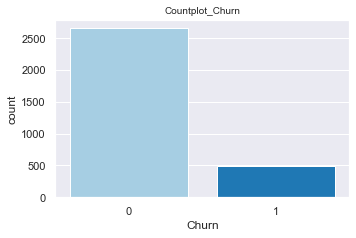

Count plot  - The countplot is used to represent the occurrence(counts) of the observation present in the categorical variable

Observation1: 
We will display the target variable and check for data imbalance using this Count plot (if there are more number of churn customers than customers who wont churn or vice versa)
There is some data imbalance, as the number of churn consumers is significantly lower than the number of customers that will not churn


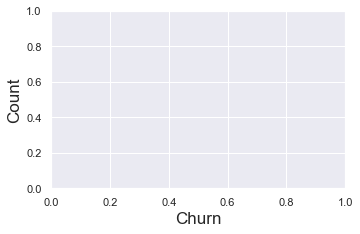

In [60]:
import seaborn as sns
countplot('Churn',df,'Countplot_Churn')
plt.xlabel("Churn",fontsize=17)
plt.ylabel("Count", fontsize=17)

print('\033[1mCount plot \033[0m - The countplot is used to represent the occurrence(counts) of the observation present in the categorical variable')
print('\n\033[1mObservation1: \033[0m\nWe will display the target variable and check for data imbalance using this Count plot (if there are more number of churn customers than customers who wont churn or vice versa)')
print('There is some data imbalance, as the number of churn consumers is significantly lower than the number of customers that will not churn')

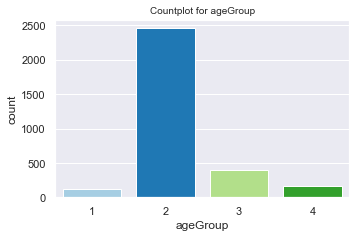

In [61]:
countplot('ageGroup',df,'Countplot for ageGroup')


Using count plot, lets see the frequency/count of different age group

There are more people between the ages of 15 and 45

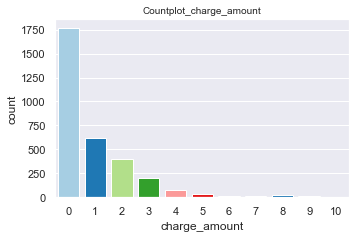

In [62]:
countplot('charge_amount',df,'Countplot_charge_amount')

Charge amount is an ordinal attribute with lowest value being 0 and highest being 9. The charge amount of 0 has the highest count

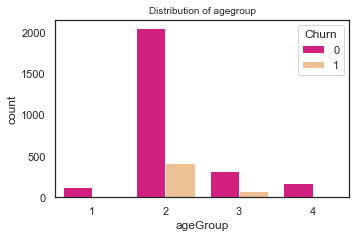

In [64]:
sns.set(style="white",font_scale = 1)
sns.countplot(x='ageGroup', hue = 'Churn',data = df, palette="Accent_r")
sns.set(rc={'figure.figsize':(5.27,3.27)})
plt.title("Distribution of agegroup",fontsize = 10)
plt.show()

We observe that there are many customers who are in the age group 30-60 and  are less likely to churn


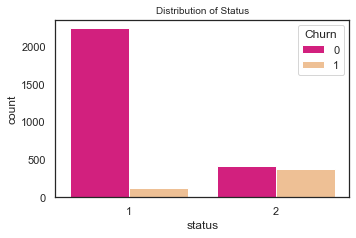

In [65]:

sns.set(style="white",font_scale = 1)
sns.countplot(x='status', hue = 'Churn',data = df, palette="Accent_r")
sns.set(rc={'figure.figsize':(5.27,3.27)})
plt.title("Distribution of Status",fontsize = 10)
plt.show()


We observe that the difference in count is huge between churn and non churn active customers(where active customers are more likely to not churn) as that of churn and non churn inactive customers


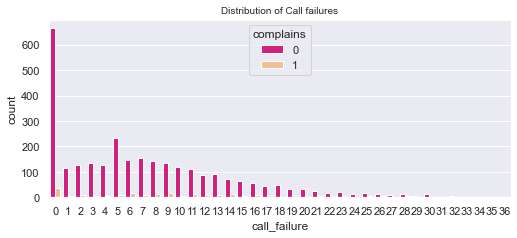

In [66]:
sns.set(style="white",font_scale = 1)
sns.set(rc={'figure.figsize':(8.27,3.27)})
sns.countplot(x='call_failure', hue = 'complains', data = df, palette="Accent_r")
plt.title("Distribution of Call failures",fontsize = 10)
plt.show()


We observe that more number of customers have 0 call failures and hence 0 complaints


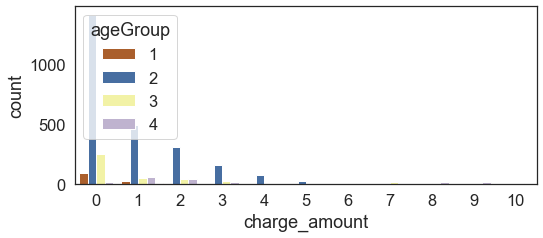

In [67]:
sns.set(style="white",font_scale = 1.5)
sns.countplot(x='charge_amount', hue = 'ageGroup',data = df, palette="Accent_r")
plt.show()

We observe that more number of customers who are in the age group of 30-60 have charge amount as o which refers to lowest pay

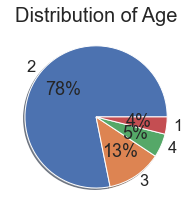

In [68]:

plt.pie(df['ageGroup'].value_counts(), labels=df['ageGroup'].value_counts().index.tolist(), autopct='%1.0f%%',shadow = True)
plt.title('Distribution of Age', fontsize = 20)
plt.show()

As we can see from the pie chart, most of the customers are of the age group 30-45

## Frequency distribution of all numerical columns :

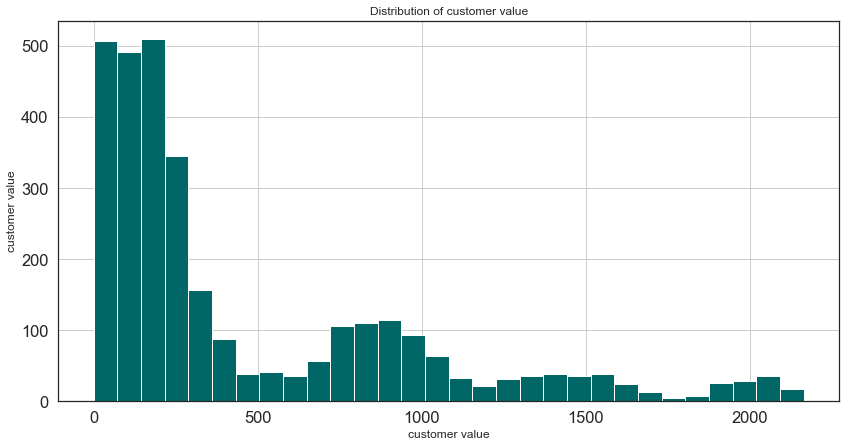

In [69]:

df['customer_value'].hist(bins=30,figsize=(14,7),color=(0,0.4,0.4))
plt.xlabel("customer value",fontsize=12)
plt.ylabel("customer value", fontsize=12)
plt.title('Distribution of customer value', fontsize = 12)
plt.show()

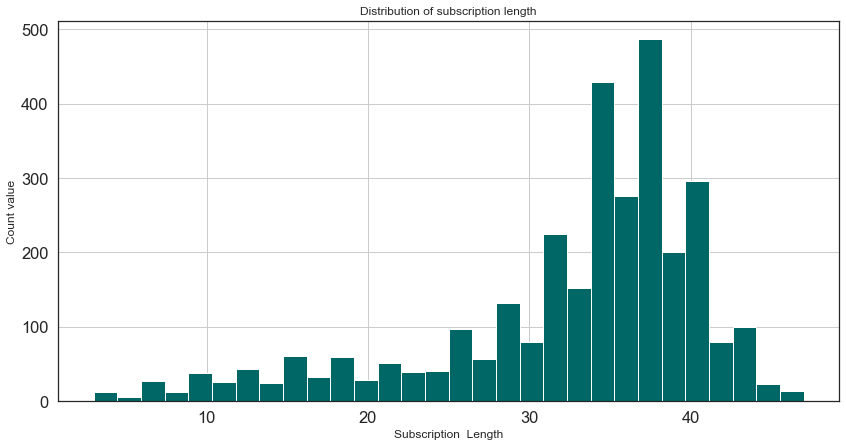

In [70]:
df['subs_len'].hist(bins=30,figsize=(14,7),color=(0,0.4,0.4))
plt.xlabel("Subscription  Length",fontsize=12)
plt.ylabel("Count value", fontsize=12)
plt.title('Distribution of subscription length', fontsize = 12)
plt.show()

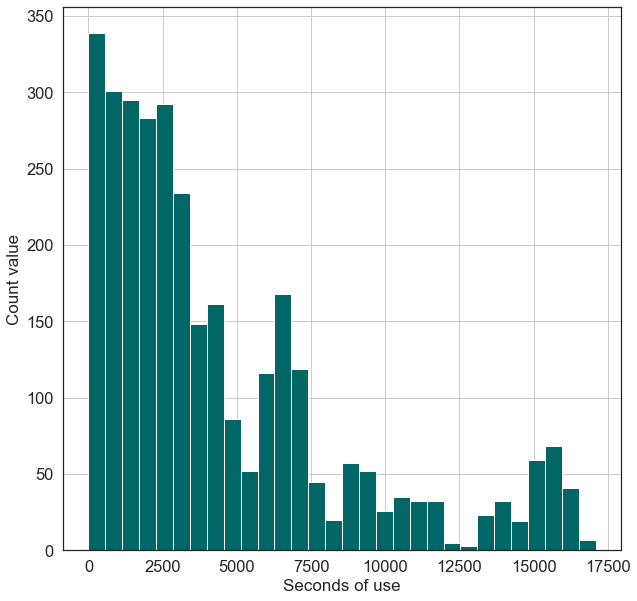

In [71]:

df['seconds_of_use'].hist(bins=30,figsize=(10,10),color=(0,0.4,0.4))
plt.xlabel("Seconds of use",fontsize=17)
plt.ylabel("Count value", fontsize=17)
plt.show()

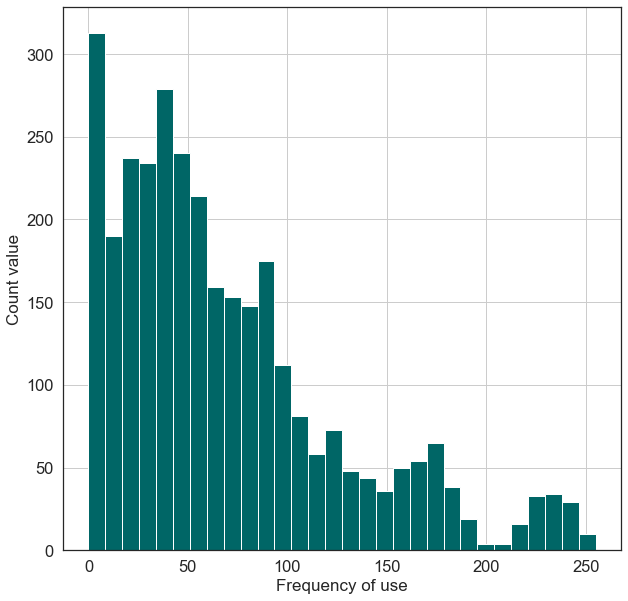

In [72]:
df['freq_of_use'].hist(bins=30,figsize=(10,10),color=(0,0.4,0.4))
plt.xlabel("Frequency of use",fontsize=17)
plt.ylabel("Count value", fontsize=17)
plt.show()

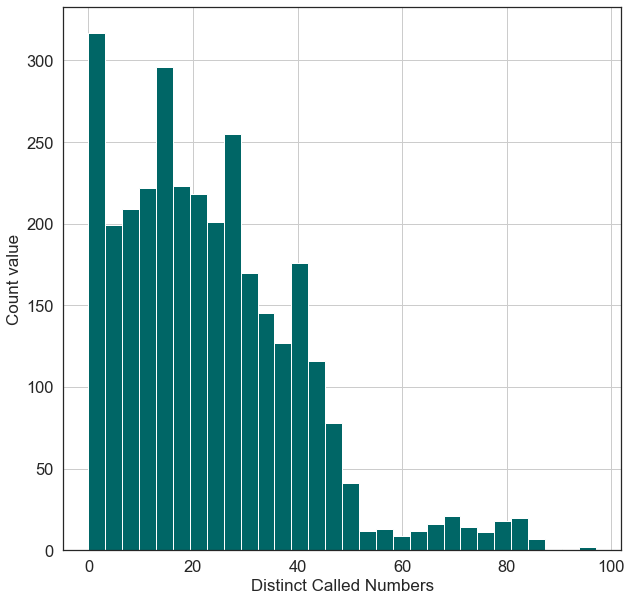

In [73]:

df['distinct_call_nums'].hist(bins=30,figsize=(10,10),color=(0,0.4,0.4))
plt.xlabel("Distinct Called Numbers",fontsize=17)
plt.ylabel("Count value", fontsize=17)
plt.show()

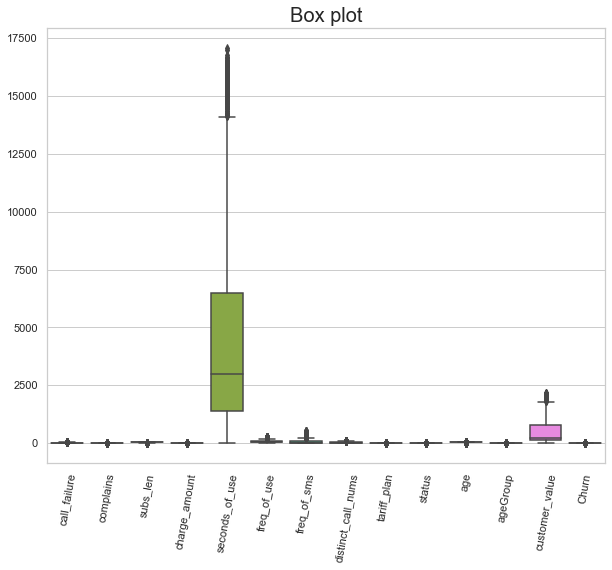

In [74]:
sns.set(style="whitegrid",font_scale=1)
plt.figure(figsize=(10,8))
sns.boxplot(data=df)
plt.xticks(rotation=80)
plt.title("Box plot",fontsize = 20)
plt.show()

As we can see there are outliers in our dataset, especially in seconds_of_use column we have more outliers

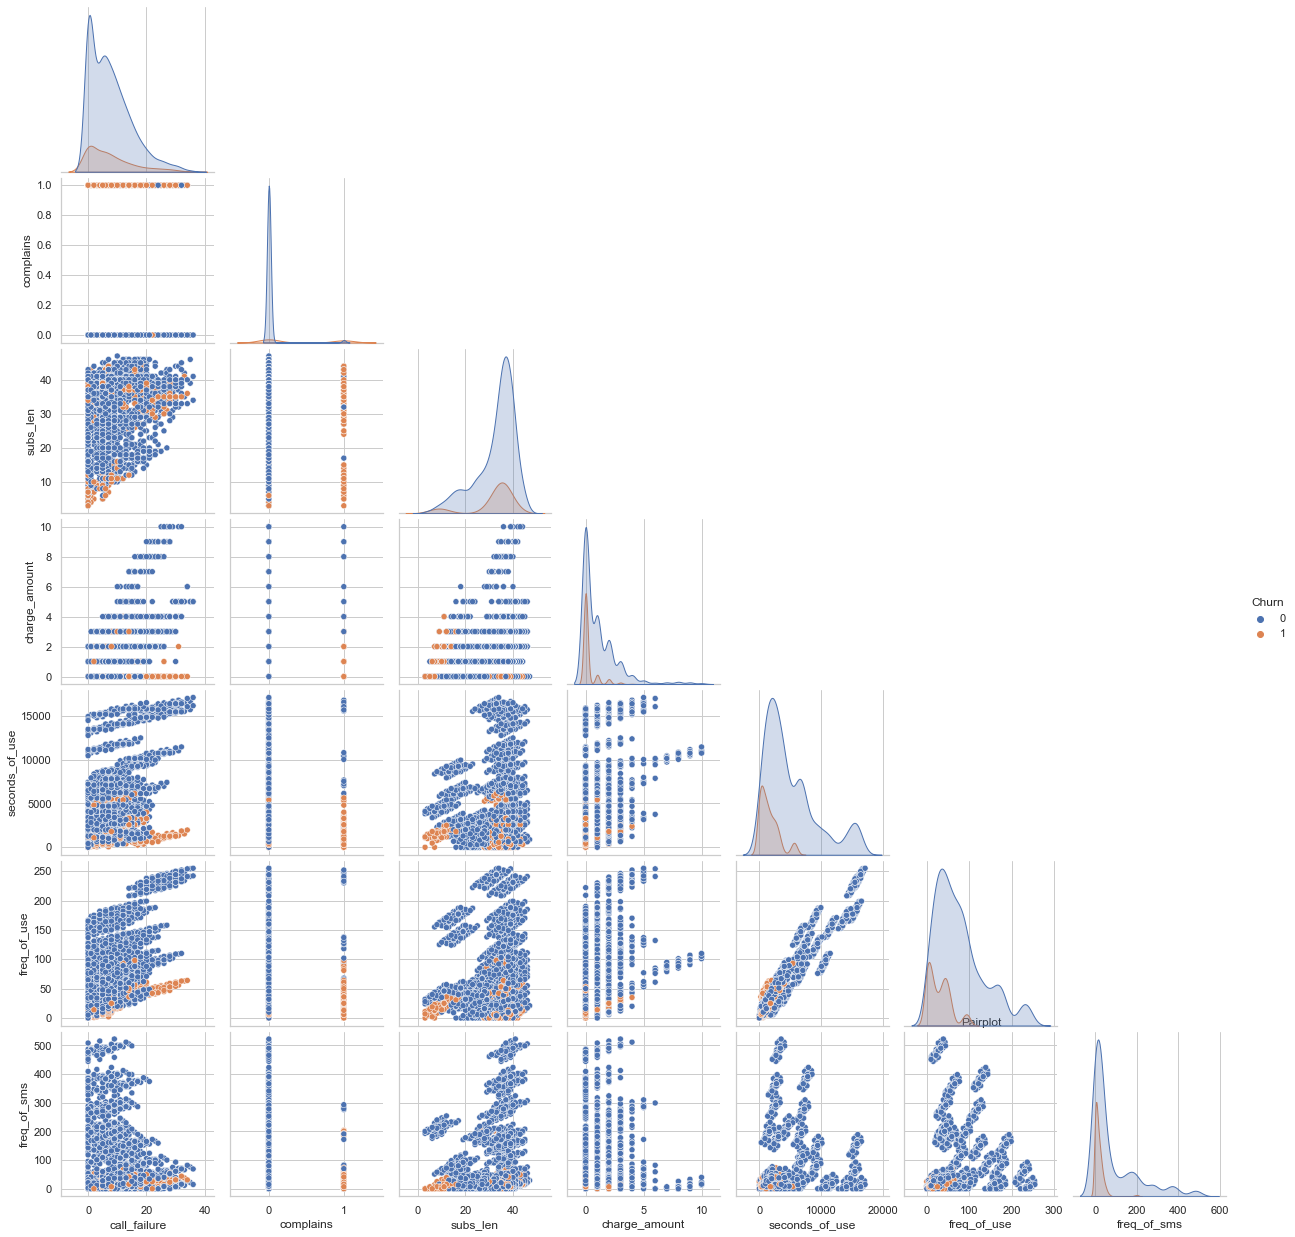

In [75]:
sns.pairplot(df,vars=df.columns[:7], corner=True, hue = 'Churn' )
sns.set(rc={'figure.figsize':(3.27,3.27)})
plt.title('Pairplot')
plt.show()

We observe a strong positive correlation between freq_of_use and seconds_of_use and also observe a slight positive correlation between charge_amount and call_failure and there is  positive correlation between freq_of_use and call_failure

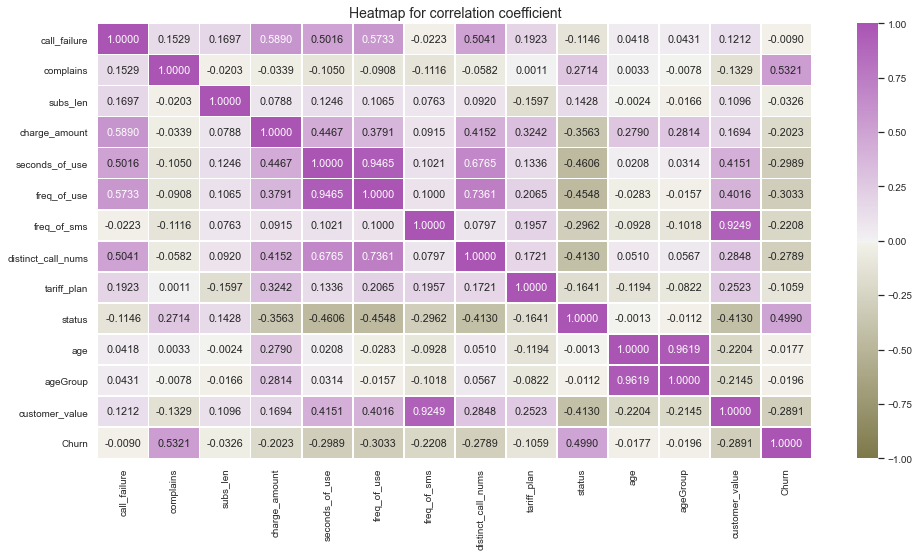

In [76]:
df_corr = df.corr()
# correlation matrix
sns.set(font_scale=0.9)
plt.figure(figsize=(16,8))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.diverging_palette(80, 302, s=60, as_cmap=True))
#plt.yticks(rotation=0)
plt.title('Heatmap for correlation coefficient',fontsize = 14)
plt.show()
print()

 The correlation coefficient between "Churn" and "complains" is relatively high (0.532). This indicates that customers who file more complaints are more likely to churn.
   - Similarly, "status" (0.499) and "customer_value" (-0.289) also show meaningful correlations with churn. This suggests that customer status and value play a role in predicting churn behavior.
   - There is a noticeable positive correlation between "Churn" and features related to usage patterns such as "seconds_of_use" (-0.299) and "freq_of_use" (-0.303). This indicates that customers who use the service less frequently or have fewer usage seconds might be more likely to churn.
   - "charge_amount" exhibits a negative correlation with "Churn" (-0.202). This implies that customers with higher charge amounts are less likely to churn, possibly indicating that higher spending customers find value in the service.
   - Age and age-related features ("age" and "ageGroup") have weak correlations with "Churn." This suggests that age might not be a strong predictor of churn in this context.
   - "tariff_plan" has a relatively low correlation with "Churn" (-0.106). This indicates that the choice of tariff plan doesn't have a strong linear relationship with churn behavior.
   - Some features are correlated with each other. For example, "freq_of_use" and "seconds_of_use" exhibit a high positive correlation (0.946), which is expected since frequent users are likely to have more usage seconds.
   - These inter-feature correlations can guide feature selection and engineering, potentially helping to reduce multicollinearity in the model.
   - Features with strong correlations with "Churn" can be important inputs for building predictive models. However, correlation doesn't imply causation, so other factors could be at play as well.
   - Multicollinearity between features might affect model stability and interpretation. Techniques like feature selection and regularization can help address this issue.

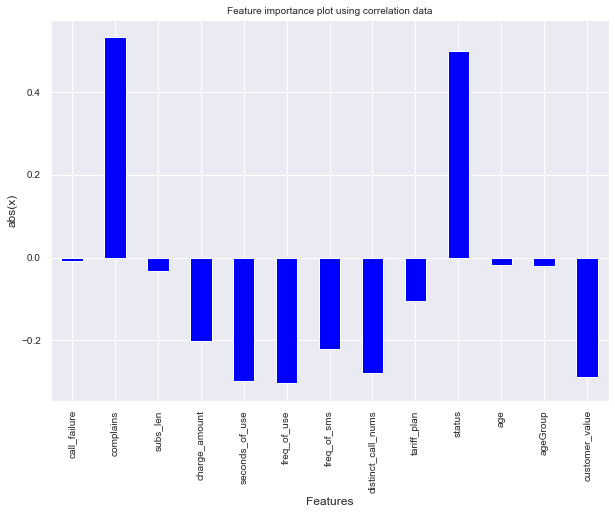

 Observation1: From the graph we observe that status and complain are influential features for this dataset


In [77]:
df.drop('Churn', axis=1).corrwith(df.Churn).plot(kind='bar', figsize=(10, 7), color='blue', 
                                                 title="Churn vs all features",fontsize = 10)
plt.xlabel("Features",fontsize=12)
plt.ylabel("abs(x)", fontsize=12)
plt.title('Feature importance plot using correlation data',fontsize = 10)
plt.show()
print('\033[1m Observation1: \033[0mFrom the graph we observe that status and complain are influential features for this dataset')


A violin plot depicts distributions of numeric data for one or more groups using density curves. The width of each curve corresponds with the approximate frequency of data points in each region. Densities are frequently accompanied by an overlaid chart type, such as box plot, to provide additional information.

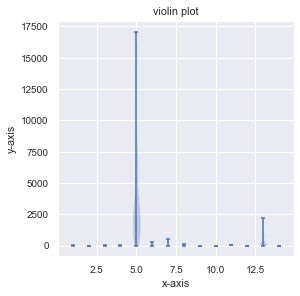

In [78]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('violin plot')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
bp = ax.violinplot(df)
plt.show()

## Feature Selection - Select-k Best

In [79]:
x = df.iloc[:,:13]
#store the output variable in y
y = df.iloc[:,13]
selector = SelectKBest(score_func=f_regression, k=13)
selector.fit(x, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = df.iloc[:,cols]

In [80]:
features_df_new['Churn'] = df['Churn']

In [81]:
features_df_new.to_csv('churn_features.csv', index = False);

In [82]:
churn_df1 = pd.read_csv('churn_features.csv')
churn_df1

,call_failure,complains,subs_len,charge_amount,seconds_of_use,freq_of_use,freq_of_sms,distinct_call_nums,tariff_plan,status,age,ageGroup,customer_value,Churn
0,8,0,38,0,4370,71,5,17,1,1,30,2,197.640,0
1,0,0,39,0,318,5,7,4,1,2,25,2,46.035,0
2,10,0,37,0,2453,60,359,24,1,1,30,2,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,15,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,15,1,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,1,25,2,721.980,0
3146,17,0,17,1,9237,177,80,42,1,1,55,4,261.210,0
3147,13,0,18,4,3157,51,38,21,1,1,30,2,280.320,0
3148,7,0,11,2,4695,46,222,12,1,1,30,2,1077.640,0


In [83]:
churn_df1['Churn'].value_counts()

0    2655
1     495
Name: Churn, dtype: int64

In [84]:
churn_df1.shape

(3150, 14)

### The given dataset has severe class imbalance. Let's try to visualise the data's imbalance

In [85]:

def countplot(x,df):
    """Countplot"""
    sns.set_style("dark")
    sns.set(rc={'figure.figsize':(8,8)})
    sns.countplot(x=x, data=churn_df1, palette=sns.color_palette("Paired", 7), saturation=10)
    plt.title('Count plot',fontsize = 20);
    plt.show()

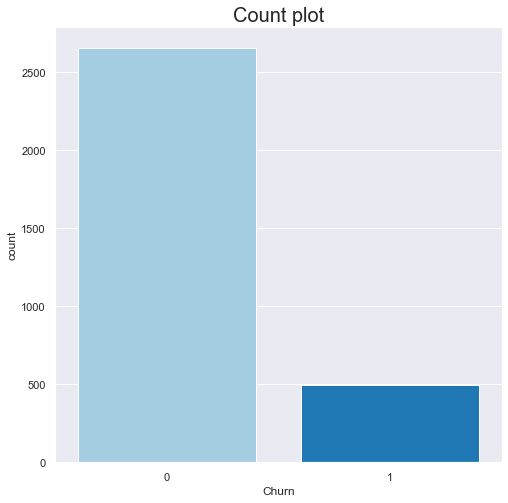

In [86]:
countplot('Churn',churn_df1)

<b> *Challenge of working with imbalanced datasets:* </b>
<br>    Most machine learning techniques will ignore, and in turn have poor performance on, the minority class
<br> Biased predictions
<br> Misleading accuracy

<b> *Ways to addressing imbalanced datasets:* </b>

<b> Synthetic Minority Oversampling Technique </b>
<br>  It involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

<b> Balance the classes by increasing minority or decreasing majority </b>

<b> Random Under-sampling</b>
- Randomly remove majority class observations
- Helps balance the dataset
- Discarded observations could have important information
- May lead to bias

<b> Undersampling majority dataset</b>
- Randomly add more minority observations by replication
- No information loss
- Prone to overfitting due to copying same information

#### **Applying StratifiedShuffleSplit on the dataset**

**Why StratifiedShuffleSplit?** For model evaluation we often use train_test_split from sklearn to split the data into train set and test set. This is fine if the sample size is large. If the sample size is small we cannot expect the same. It will make sure that the data is split in a way that the splits will have equal proportions of the classes If it is not so then we are training on one distribution and predicting from another distribution!

In [87]:
# cross-validation with 5 splits
cv = StratifiedShuffleSplit(n_splits=5, random_state = 88)
#split the data
X = churn_df1.iloc[:,:13]
#store the output variable in y
y = churn_df1.iloc[:,13]

#### **Feature scaling**
**Min-Max scaling** Min-max scaling will replace every value in a column with a new value using a formula(m = (x -xmin) / (xmax -xmin). The purpose behind this is to get the values of all columns in the same range i.e [0-1]

In [88]:
# Scaling data to 0 to 1
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
# split data to X train/test and Y train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

### Applying SMOTE technique

In [89]:
# Applying SMOTE technique
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_smote, y_smote  = sm.fit_resample(X, y)
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_smote, y_smote,
                                                                            test_size=0.30, random_state=42,
                                                                            stratify = y_smote)

# Checking if the data is balanced or not
counter = Counter(y_smote)
print(counter)

Counter({0: 2655, 1: 2655})


In [90]:
# Checking if the data is balanced or not
counter = Counter(y_smote)
print(counter)

Counter({0: 2655, 1: 2655})


Here, after applying SMOTE we treat the imbalanced data and we are able to get same number of values for both the categories i.e, churn and non-churn

In [91]:
#scale smote data
scaler = MinMaxScaler()
scaler.fit(X_smote)
X_scaled_smote = scaler.transform(X_smote)

In [92]:
# split data to X train/test and Y train/test
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_scaled_smote, y_smote, test_size=0.30, random_state=100, stratify = y_smote)

### Resampling technique - Undersampling

<b> *Under-sampling balances the dataset by reducing the size of the abundant class* </b>

In [93]:
# class count
class_count_0, class_count_1 = churn_df1['Churn'].value_counts()
class_0 = churn_df1[churn_df1['Churn'] == 0]
class_1 = churn_df1[churn_df1['Churn'] == 1]
# print the shape of the class
print('class 0:', class_0.shape)
print('\nclass 1:', class_1.shape)

class 0: (2655, 14)

class 1: (495, 14)


total class of 1 and 0:
 1    495
0    495
Name: Churn, dtype: int64


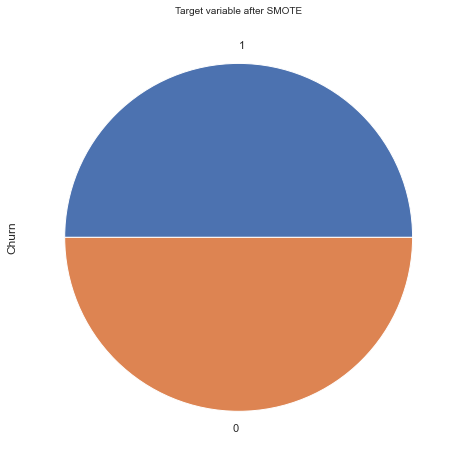

In [94]:
# Undersample the majority class, class_count_0, to the same count as class_count_1.
class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)
# Print total number of samples in each class to check if data is balanced
print("total class of 1 and 0:\n",test_under['Churn'].value_counts())
# Let's visualize and check for data imbalance
test_under['Churn'].value_counts().plot(kind='pie', title='Count (target)')
sns.set(rc={'figure.figsize':(5,5)})
plt.title('Target variable after SMOTE',fontsize = 10);
plt.show()

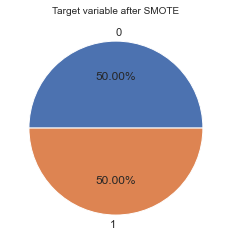

In [95]:
# Churn distribution 
sn.set(style="whitegrid",font_scale=1)
plt.figure(figsize=(4,4))
plt.pie(test_under['Churn'].value_counts(), labels=test_under['Churn'].unique(), autopct='%1.2f%%')
plt.title('Target variable after SMOTE', fontsize = 10)
plt.show()

In [96]:
#split the data
X = test_under.iloc[:,:13]
#store the output variable in y
y = test_under.iloc[:,13]
# Scaling data to 0 to 1
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
# split data to X train/test and Y train/test
X_train_undersampling, X_test_undersampling, Y_train_undersampling, Y_test_undersampling = train_test_split(X, y, test_size=0.30, random_state=100, stratify = y)

In [97]:
# display test scores and return result string and indexes of false samples
def display_test_scores(test, pred,pred1):
    str_out = "\n"
    str_out += ("#####  TEST SCORES  #####\n--------------------")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(test, pred1[:,1])
    str_out += ("AUC: {:.4f}\n".format(auc))
    
    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n--------------------\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n--------------------\n")

    #print classification report
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

## **Model building**

**XGBOOST** XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. Where the idea is to boost weak learners by minimizing errors by gradient descent algorithm. Considered very efficient and fast compared to other algorithms

### XGBoost model without sampling


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9683

AUC: 0.9917
CONFUSION MATRIX:
--------------------
[[785  12]
 [ 18 130]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       797
           1       0.92      0.88      0.90       148

    accuracy                           0.97       945
   macro avg       0.95      0.93      0.94       945
weighted avg       0.97      0.97      0.97       945

Accuracy: 0.968254
Precision: 0.915493
Recall: 0.878378
F1 score: 0.896552


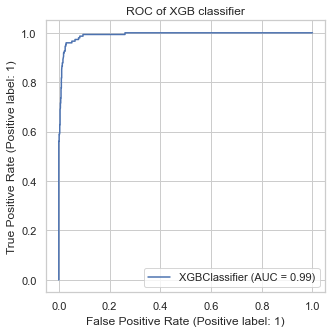


Observation: 
Built this model with imbalance data and as XGBoost can offer better performance on binary classification problems with a severe class imbalance, here we observe that the model is performing well and has good precision as well as recall score


In [98]:
# Train xgbclassifier on train data
xgb = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on train data
xgb.fit(X_train, Y_train)
# make predictions for test data
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_test, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb = accuracy_score(Y_test,predictions)
print('Accuracy: %f' % acc_xgb)
# precision tp / (tp + fp)
prec_xgb = precision_score(Y_test,predictions)
print('Precision: %f' % prec_xgb)
# recall: tp / (tp + fn)
recall_xgb = recall_score(Y_test,predictions)
print('Recall: %f' % recall_xgb)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb = f1_score(Y_test,predictions)
print('F1 score: %f' % f1_xgb)
#plot ROC curve
metrics.plot_roc_curve(xgb, X_test, Y_test)
plt.title("ROC of XGB classifier")
plt.show()
print("\n\033[1mObservation: \033[0m\nBuilt this model with imbalance data and as XGBoost can offer better performance on binary classification problems with a severe class imbalance, here we observe that the model is performing well and has good precision as well as recall score")


### XGBoost model with SMOTE 


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9736

AUC: 0.9979
CONFUSION MATRIX:
--------------------
[[770  27]
 [ 15 781]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       797
           1       0.97      0.98      0.97       796

    accuracy                           0.97      1593
   macro avg       0.97      0.97      0.97      1593
weighted avg       0.97      0.97      0.97      1593

Accuracy: 0.973635
Precision: 0.966584
Recall: 0.981156
F1 score: 0.973815


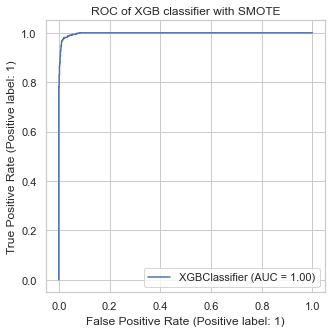

In [99]:
# Train xgbclassifier on smote_train data
xgb_smote_clf = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on smote_train data
xgb_smote_clf.fit(X_smote_train,Y_smote_train)
# make predictions for test data
y_pred = xgb_smote_clf.predict(X_smote_test)
y_pred_prob = xgb_smote_clf.predict_proba(X_smote_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_smote_test, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb_smote = accuracy_score(Y_smote_test,predictions)
print('Accuracy: %f' % acc_xgb_smote)
# precision tp / (tp + fp)
prec_xgb_smote = precision_score(Y_smote_test,predictions)
print('Precision: %f' % prec_xgb_smote)
# recall: tp / (tp + fn)
recall_xgb_smote = recall_score(Y_smote_test,predictions)
print('Recall: %f' % recall_xgb_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb_smote = f1_score(Y_smote_test,predictions)
print('F1 score: %f' % f1_xgb_smote)
#plot ROC curve
metrics.plot_roc_curve(xgb_smote_clf, X_smote_test, Y_smote_test)
plt.title("ROC of XGB classifier with SMOTE")
plt.show()

### Hyperparameter tuning wrt SMOTE imputed data

<b> *Now Let's tune some of the parameters to increase the performance of our model by training it on best parameters generated by this following hyperparameter tuning process* </b>

In [101]:
n_estimators = [20,100, 500]
booster = ['gbtree','gblinear']
learning_rate = [0.1,0.20,0.02,0.05,0.01]
for i in n_estimators:
    for k in booster:
        for m in learning_rate:
            xgb = XGBClassifier(eval_metric='mlogloss',n_estimators = i,booster=k,learning_rate = m)
            # Fit xgbclassifier on train data
            xgb.fit(X_smote_train, Y_smote_train)
            # make predictions for test data
            y_pred = xgb.predict(X_smote_test)
            predictions = [round(value) for value in y_pred]
            # evaluate predictions
            accuracy = accuracy_score(Y_smote_test, predictions)
            #print("Accuracy: %.2f%%" % (accuracy * 100.0))
            if accuracy > 0.93:
                print("Best parameters: n_estimators = %d  booster = %s learning_rate = %f, accuracy = %.3f" % (i,k,m,accuracy))

Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.100000, accuracy = 0.942
Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.200000, accuracy = 0.957
Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.050000, accuracy = 0.931
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.100000, accuracy = 0.970
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.200000, accuracy = 0.976
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.020000, accuracy = 0.944
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.050000, accuracy = 0.960
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.100000, accuracy = 0.976
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.200000, accuracy = 0.979
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.020000, accuracy = 0.970
Best parameters: n_estimators = 5

<b> *After tuning the parameters, the best accuracy that was obtained is 96.6% and the best values for the parameters are as follow:*</b>
- n_estimators : 500
- booster : gbtree
- learning_rate : 0.05


### XGBoost model with SMOTE (Using best parameters obtained during hyperparameter tuning)


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9743

AUC: 0.9976
CONFUSION MATRIX:
--------------------
[[770  27]
 [ 14 782]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       797
           1       0.97      0.98      0.97       796

    accuracy                           0.97      1593
   macro avg       0.97      0.97      0.97      1593
weighted avg       0.97      0.97      0.97      1593

Accuracy: 0.974262
Precision: 0.966625
Recall: 0.982412
F1 score: 0.974455


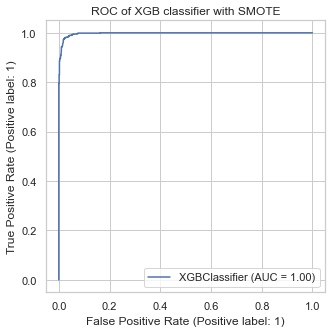

In [102]:
# Train xgbclassifier on smote_train data
xgb_smote_clf = XGBClassifier(eval_metric='mlogloss',n_estimators = 500, booster = 'gbtree', learning_rate = 0.05)
# Fit xgbclassifier on smote_train data
xgb_smote_clf.fit(X_smote_train,Y_smote_train)
# make predictions for test data
y_pred = xgb_smote_clf.predict(X_smote_test)
y_pred_prob = xgb_smote_clf.predict_proba(X_smote_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_smote_test, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb_smote_best = accuracy_score(Y_smote_test,predictions)
print('Accuracy: %f' % acc_xgb_smote_best)
# precision tp / (tp + fp)
prec_xgb_smote_best = precision_score(Y_smote_test,predictions)
print('Precision: %f' % prec_xgb_smote_best)
# recall: tp / (tp + fn)
recall_xgb_smote_best = recall_score(Y_smote_test,predictions)
print('Recall: %f' % recall_xgb_smote_best)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb_smote_best = f1_score(Y_smote_test,predictions)
print('F1 score: %f' % f1_xgb_smote_best)
#plot ROC curve
metrics.plot_roc_curve(xgb_smote_clf, X_smote_test, Y_smote_test)
plt.title("ROC of XGB classifier with SMOTE")
plt.show()

### **Naive-Bayes Classifier without sampling**

**Naïve Bayes**  Naive Bayes is a probabilistic machine learning algorithm based on the Bayes Theorem, used in a wide variety of classification tasks

**Gaussian Naive Bayes**  A Gaussian Naive Bayes algorithm is a sort of NB algorithm that is unique. When the features have continuous values, it's employed particularly. It's also expected that all of the characteristics have a gaussian distribution, or a normal distribution.

**Complement Naive Bayes**  Complement Naive Bayes is well-suited to dealing with unbalanced datasets. Instead of calculating the probability of an item belonging to a certain class, we calculate the probability of the item belonging to all classes in complement Naive Bayes.


*************************GaussianNB()****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.7333

AUC: 0.9026
CONFUSION MATRIX:
--------------------
[[557 240]
 [ 12 136]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       797
           1       0.36      0.92      0.52       148

    accuracy                           0.73       945
   macro avg       0.67      0.81      0.67       945
weighted avg       0.88      0.73      0.77       945

Accuracy: 0.733333
Precision: 0.361702
Recall: 0.918919
F1 score: 0.519084


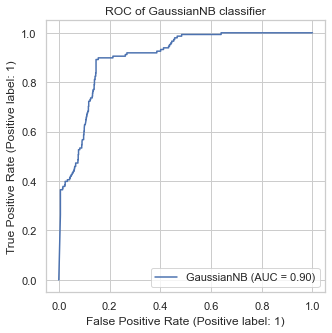


****************************MultinomialNB()*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8952

AUC: 0.9175
CONFUSION MATRIX:
--------------------
[[792   5]
 [ 94  54]]

--------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       797
           1       0.92      0.36      0.52       148

    accuracy                           0.90       945
   macro avg       0.90      0.68      0.73       945
weighted avg       0.90      0.90      0.88       945

Accuracy: 0.895238
Precision: 0.915254
Recall: 0.364865
F1 score: 0.521739


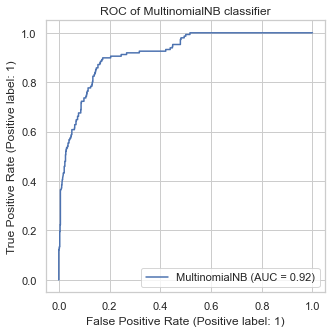


****************************ComplementNB_clf()*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8476

AUC: 0.9175
CONFUSION MATRIX:
--------------------
[[674 123]
 [ 21 127]]

--------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       797
           1       0.51      0.86      0.64       148

    accuracy                           0.85       945
   macro avg       0.74      0.85      0.77       945
weighted avg       0.90      0.85      0.86       945

Accuracy: 0.847619
Precision: 0.508000
Recall: 0.858108
F1 score: 0.638191


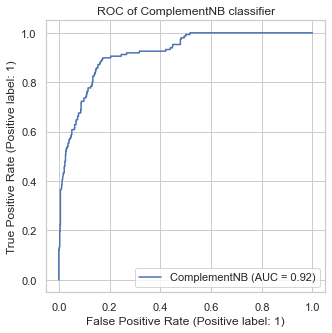

In [103]:
# Naive-Bayes with different approaches
# fit GaussianNB classifier
# grid search for parameters
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, Y_train)



# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (gaussian_clf.best_params_, gaussian_clf.best_score_))

# prediction results
y_pred = gaussian_clf.predict(X_test)
y_pred_prob = gaussian_clf.predict_proba(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n*************************GaussianNB()****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_gaussian_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_gaussian_clf)
# precision tp / (tp + fp)
prec_gaussian_clf = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_gaussian_clf)
# recall: tp / (tp + fn)
recall_gaussian_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_gaussian_clf)
# f1: 2 tp / (2 tp + fp + fn)
f1_gaussian_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_gaussian_clf)

#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_test, Y_test)
plt.title("ROC of GaussianNB classifier")
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_train, Y_train)

y_pred = Multinomial_clf.predict(X_test)
y_pred_prob = Multinomial_clf.predict_proba(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n****************************MultinomialNB()*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_Multinomial_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_Multinomial_clf)
# precision tp / (tp + fp)
prec_Multinomial_clf = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_Multinomial_clf)
# recall: tp / (tp + fn)
recall_Multinomial_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_Multinomial_clf)
# f1: 2 tp / (2 tp + fp + fn)
f1_Multinomial_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_Multinomial_clf)
#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_test, Y_test)
plt.title("ROC of MultinomialNB classifier")
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_train, Y_train)


# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (Multinomial_clf.best_params_, Multinomial_clf.best_score_))

# prediction results
y_pred = ComplementNB_clf.predict(X_test)
y_pred_prob = ComplementNB_clf.predict_proba(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n****************************ComplementNB_clf()*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_ComplementNB_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_ComplementNB_clf)
# precision tp / (tp + fp)
prec_ComplementNB_clf = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_ComplementNB_clf)
# recall: tp / (tp + fn)
recall_ComplementNB_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_ComplementNB_clf)
# f1: 2 tp / (2 tp + fp + fn)
f1_ComplementNB_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_ComplementNB_clf)
#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_test, Y_test)
plt.title("ROC of ComplementNB classifier")
plt.show()

### Naive-Bayes Classifier using SMOTE sampling


*************************GaussianNB() with SMOTE sampling****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.7784

AUC: 0.9049
CONFUSION MATRIX:
--------------------
[[498 299]
 [ 54 742]]

--------------------
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       797
           1       0.71      0.93      0.81       796

    accuracy                           0.78      1593
   macro avg       0.81      0.78      0.77      1593
weighted avg       0.81      0.78      0.77      1593

Accuracy: 0.778406
Precision: 0.712776
Recall: 0.932161
F1 score: 0.807839


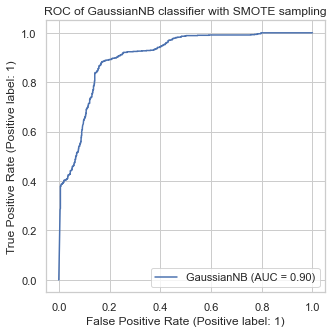


****************************MultinomialNB() with SMOTE sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8431

AUC: 0.9202
CONFUSION MATRIX:
--------------------
[[669 128]
 [122 674]]

--------------------
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       797
           1       0.84      0.85      0.84       796

    accuracy                           0.84      1593
   macro avg       0.84      0.84      0.84      1593
weighted avg       0.84      0.84      0.84      1593

Accuracy: 0.843063
Precision: 0.840399
Recall: 0.846734
F1 score: 0.843554


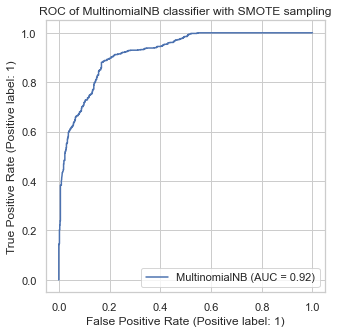


****************************ComplementNB() with SMOTE sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8431

AUC: 0.9202
CONFUSION MATRIX:
--------------------
[[669 128]
 [122 674]]

--------------------
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       797
           1       0.84      0.85      0.84       796

    accuracy                           0.84      1593
   macro avg       0.84      0.84      0.84      1593
weighted avg       0.84      0.84      0.84      1593

Accuracy: 0.843063
Precision: 0.840399
Recall: 0.846734
F1 score: 0.843554


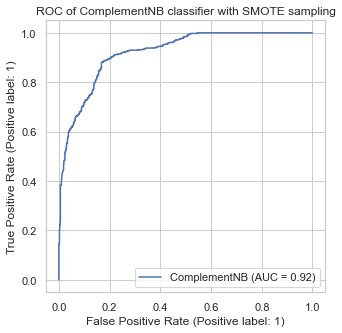

In [104]:
# Naive-Bayes with different approaches
# fit GaussianNB classifier
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_smote_train, Y_smote_train)
y_pred = gaussian_clf.predict(X_smote_test)
y_pred_prob = gaussian_clf.predict_proba(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n*************************GaussianNB() with SMOTE sampling****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_gaussian_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_gaussian_clf_smote)
# precision tp / (tp + fp)
prec_gaussian_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_gaussian_clf_smote)
# recall: tp / (tp + fn)
recall_gaussian_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_gaussian_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_gaussian_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_gaussian_clf_smote)


#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)
plt.title("ROC of GaussianNB classifier with SMOTE sampling")
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_smote_train, Y_smote_train)

# prediction results
y_pred = Multinomial_clf.predict(X_smote_test)
y_pred_prob = Multinomial_clf.predict_proba(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n****************************MultinomialNB() with SMOTE sampling*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_Multinomial_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_Multinomial_clf_smote)
# precision tp / (tp + fp)
prec_Multinomial_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_Multinomial_clf_smote)
# recall: tp / (tp + fn)
recall_Multinomial_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_Multinomial_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_Multinomial_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_Multinomial_clf_smote)


#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_smote_test, Y_smote_test)
plt.title("ROC of MultinomialNB classifier with SMOTE sampling")
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_smote_train, Y_smote_train)

# prediction results
y_pred = ComplementNB_clf.predict(X_smote_test)
y_pred_prob = ComplementNB_clf.predict_proba(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n****************************ComplementNB() with SMOTE sampling*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_ComplementNB_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_ComplementNB_clf_smote)
# precision tp / (tp + fp)
prec_ComplementNB_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_ComplementNB_clf_smote)
# recall: tp / (tp + fn)
recall_ComplementNB_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_ComplementNB_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_ComplementNB_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_ComplementNB_clf_smote)

#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_smote_test, Y_smote_test)
plt.title("ROC of ComplementNB classifier with SMOTE sampling")
plt.show()

### **SVM Classifier without sampling**
**Support vector machines** The Support Vector Machine, or SVM, is a linear model that can be used to solve classification and regression issues. It can solve both linear and nonlinear problems and is useful for a wide range of applications.  The algorithm generates a line or hyperplane that divides the data into categories.

**Grid searchcv** It can assist you in looping over predefined hyperparameters and fitting your estimator (model) to your training data. Finally, you can choose the most appropriate hyperparameters from the list.

The best parameters are {'C': 100, 'class_weight': None, 'kernel': 'rbf'} with a score of 0.9510


*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9503

AUC: 0.9813
CONFUSION MATRIX:
--------------------
[[788   9]
 [ 38 110]]

--------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       797
           1       0.92      0.74      0.82       148

    accuracy                           0.95       945
   macro avg       0.94      0.87      0.90       945
weighted avg       0.95      0.95      0.95       945


Run time for train&test cv SVM :  75.44875478744507
Accuracy: 0.950265
Precision: 0.924370
Recall: 0.743243
F1 score: 0.823970


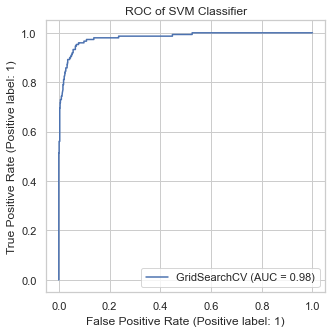

In [105]:
# SVM Classifier with different approaches
import time

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000, tol=1e-5,probability = True), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_train, Y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_test)
y_pred_prob = SVM_grid_clf.predict_proba(X_test)

end_time=time.time()




# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n*************************SVM Classifier****************************************\n")
print(results)

print("\nRun time for train&test cv SVM : ", end_time-start_time)

# accuracy: (tp + tn) / (p + n)
acc_svm_clf_undersampling = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_svm_clf_undersampling)
# precision tp / (tp + fp)
prec_svm_clf_undersampling = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_svm_clf_undersampling)
# recall: tp / (tp + fn)
recall_svm_clf_undersampling = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_svm_clf_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_clf_undersampling = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_svm_clf_undersampling)
#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_test, Y_test)
plt.title("ROC of SVM Classifier")
plt.show()

### SVM Classifier with SMOTE

The best parameters are {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'} with a score of 0.9513


Run time for train&test cv SVM :  333.9106822013855

*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9598

AUC: 0.9874
CONFUSION MATRIX:
--------------------
[[746  51]
 [ 13 783]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       797
           1       0.94      0.98      0.96       796

    accuracy                           0.96      1593
   macro avg       0.96      0.96      0.96      1593
weighted avg       0.96      0.96      0.96      1593

Accuracy: 0.959824
Precision: 0.938849
Recall: 0.983668
F1 score: 0.960736


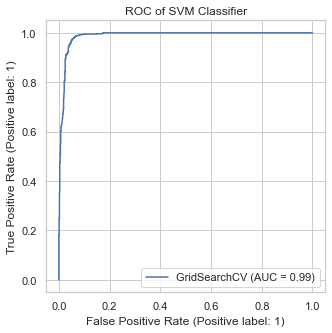

In [106]:

# SVM Classifier with different approaches

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000,probability = True), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_smote_train, Y_smote_train)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_smote_test)
y_pred_prob = SVM_grid_clf.predict_proba(X_smote_test)

end_time=time.time()

print("\nRun time for train&test cv SVM : ", end_time-start_time)


# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n*************************SVM Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_svm_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_svm_clf_smote)
# precision tp / (tp + fp)
prec_svm_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_svm_clf_smote)
# recall: tp / (tp + fn)
recall_svm_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_svm_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_svm_clf_smote)
#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of SVM Classifier")
plt.show()

### **Decision Tree Classifier without sampling**

**Decision tree** A decision tree is a sort of supervised machine learning that categorises or predicts outcomes based on the answers to a previous set of questions.

In [ ]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_test, Y_test)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_test)
y_pred_prob = dt_grid_clf.predict_proba(X_test)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_dt_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_dt_clf )
# precision tp / (tp + fp)
prec_dt_clf  = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_dt_clf )
# recall: tp / (tp + fn)
recall_dt_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_dt_clf )
# f1: 2 tp / (2 tp + fp + fn)
f1_dt_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_dt_clf )


#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_test, Y_test)
plt.title("ROC of Decision Tree Classifier")
plt.show()

### Decision Tree Classifier with SMOTE

In [ ]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_smote_train, Y_smote_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_smote_test)
y_pred_prob = dt_grid_clf.predict_proba(X_smote_test)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_dt_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_dt_clf_smote )
# precision tp / (tp + fp)
prec_dt_clf_smote  = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_dt_clf_smote )
# recall: tp / (tp + fn)
recall_dt_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_dt_clf_smote )
# f1: 2 tp / (2 tp + fp + fn)
f1_dt_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_dt_clf_smote )
#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of Decision Tree Classifier")
plt.show()

### Final ROC for multiple classifiers

In [ ]:
#without SMOTE

disp = metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)

metrics.plot_roc_curve(Multinomial_clf, X_test, Y_test, ax = disp.ax_)
metrics.plot_roc_curve(ComplementNB_clf, X_test, Y_test, ax = disp.ax_)
metrics.plot_roc_curve(SVM_grid_clf, X_test, Y_test,ax = disp.ax_, name ='SVM_Classifier' )
metrics.plot_roc_curve(dt_grid_clf, X_test, Y_test, ax = disp.ax_, name = 'Decision_tree_classifier')
metrics.plot_roc_curve(xgb, X_test, Y_test, ax = disp.ax_)
plt.title('ROC Graph for imbalanced data', fontsize = 20)
plt.show()

In [ ]:
# With undersampling
plt.figure(figsize=(32, 32))
disp = metrics.plot_roc_curve(gaussian_clf, X_test_undersampling, Y_test_undersampling)
metrics.plot_roc_curve(Multinomial_clf, X_test_undersampling, Y_test_undersampling, ax = disp.ax_)
metrics.plot_roc_curve(ComplementNB_clf, X_test_undersampling, Y_test_undersampling, ax = disp.ax_)
metrics.plot_roc_curve(SVM_grid_clf, X_test_undersampling, Y_test_undersampling,ax = disp.ax_, name ='SVM_Classifier' )
metrics.plot_roc_curve(dt_grid_clf, X_test_undersampling, Y_test_undersampling, ax = disp.ax_,
                       name = 'Decision_tree_classifier')
metrics.plot_roc_curve(xgb, X_test_undersampling, Y_test_undersampling, ax = disp.ax_)
plt.title('ROC Graph with Undersampling', fontsize = 10)
plt.show()

In [ ]:
# With SMOTE
plt.figure(figsize=(32, 32))
disp = metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)
metrics.plot_roc_curve(Multinomial_clf, X_smote_test, Y_smote_test, ax = disp.ax_)
metrics.plot_roc_curve(ComplementNB_clf, X_smote_test, Y_smote_test, ax = disp.ax_)
metrics.plot_roc_curve(SVM_grid_clf, X_smote_test, Y_smote_test,ax = disp.ax_, name ='SVM_Classifier' )
metrics.plot_roc_curve(dt_grid_clf, X_smote_test, Y_smote_test, ax = disp.ax_, name = 'Decision_tree_classifier')
metrics.plot_roc_curve(xgb, X_smote_test, Y_smote_test, ax = disp.ax_)
plt.title('ROC Graph with SMOTE data', fontsize = 10)
plt.show()